# Annotate RBC-GEM

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    MODEL_PATH,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    read_rbc_model,
    write_rbc_model,
    show_versions,
)

from rbc_gem_utils.util import split_string
# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
cobra      0.29.0
depinfo     2.2.0
matplotlib  3.8.2
memote     0.16.1
notebook    7.0.6
requests   2.31.0
scipy      1.11.4
seaborn    0.13.0

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
--------------------
Darwin  22.6.0-x86_64
CPython        3.12.0


### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model
### Current Version: 0.2.0

In [3]:
old_model = read_rbc_model(filetype="xml")
old_model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,iAB_RBC_283
Memory address,153a26510
Number of metabolites,342
Number of reactions,469
Number of genes,349
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Set annotations on model

In [4]:
replace_annotations = True
annotation_types = ["reactions", "metabolites", "genes"]
model = old_model.copy()

for annotation_type in annotation_types:
    df_annotation = pd.read_csv(
        f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", 
        sep="\t", 
        index_col=0,
        dtype=str,
    )
    for idx, row in df_annotation.set_index(annotation_type).iterrows():
        item = getattr(model, annotation_type).get_by_id(idx)
        values = {k: split_string(v) for k, v in row.dropna().to_dict().items()}
        values.update({k: v[0] for k, v in values.items() if len(v) == 1})
        if replace_annotations:
            item.annotation = values
        else:
            item.annotation.update(values)
df_annotation

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpbv6_ckft.lp
Reading time = 0.00 seconds
: 342 rows, 938 columns, 3344 nonzeros


,genes,hprd,ncbigi,sbo,mgi,hgnc.symbol,uniprot,ccds,uniprot.isoform,ncbigene,refseq,drugbank,mim,ensembl
0,10007_AT1,09048,NaN,SBO:0000243,MGI:1347054,GNPDA1,P46926,CCDS4272.1,P46926-1,10007,NP_005462.1;XP_006714810.1,DB02445;DB02379;DB03951,601798,ENSG00000113552
1,100_AT1,NaN,NaN,SBO:0000243,MGI:87916,ADA,P00813,CCDS13335.1,P00813-1,100,NP_000013.2,DB07711;DB07783;DB07786;DB04218;DB07785;DB0301...,102700;608958,ENSG00000196839
2,10201_AT1,NaN,NaN,SBO:0000243,MGI:1861676,NME6,O75414,CCDS77734.1,O75414-1,10201,NP_001295355.1;NP_001295356.1;NP_001295357.1,NaN,608294,ENSG00000172113
3,10257_AT1,NaN,NaN,SBO:0000243,MGI:2443111,ABCC4,O15439,CCDS9474.1,O15439-1,10257,NP_005836.2,DB00718;DB00770;DB01076;DB00171;DB01327;DB0048...,605250,ENSG00000125257
4,10327_AT1,NaN,NaN,SBO:0000243,MGI:1929955,AKR1A1,P14550,CCDS523.1,P14550-1,10327,NP_001189342.1;NP_001189343.1;NP_006057.1;NP_6...,DB08904;DB09130;DB00997;DB00898;DB06077;DB0015...,103830,ENSG00000117448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,8867_AT2,NaN,NaN,SBO:0000243,MGI:1354961,SYNJ1,O43426,CCDS33540.3,O43426-2,8867,NP_982271.2,NaN,604297;615530;617389,ENSG00000159082
345,9162_AT1,07238,1012282641;1034657385;1034657393;1034657397;10...,SBO:0000243,MGI:2443430,DGKI,O75912,CCDS5845.1,O75912-1,9162,NP_001308637.1;NP_001308638.1;NP_001308639.1;N...,DB14001,604072,ENSG00000157680
346,9429_AT1,NaN,NaN,SBO:0000243,MGI:1347061;MGI:1351624,ABCG2,Q9UNQ0,CCDS3628.1,Q9UNQ0-1,9429,NP_004818.2;XP_011530722.1,DB12001;DB08916;DB11363;DB00437;DB12015;DB0349...,138900;603756;614490,ENSG00000118777
347,9468_AT1,05376,NaN,SBO:0000243,MGI:2147987,PCYT1B,Q9Y5K3,CCDS14213.1,Q9Y5K3-1,9468,NP_004836.2,DB00122;DB14006,300948,ENSG00000102230


### Compare before overwriting

In [5]:
df_old_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(old_model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_old_model[annotation_type] = get_annotation_df(
        getattr(old_model, annotation_type), 
        sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)

df_new_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_new_model[annotation_type] = get_annotation_df(
        getattr(model, annotation_type), 
        sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)

<Axes: xlabel='reactions'>

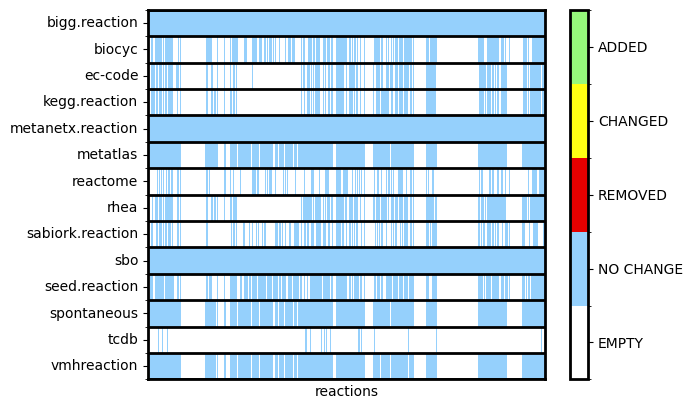

In [6]:
annotation_type = "reactions"
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='metabolites'>

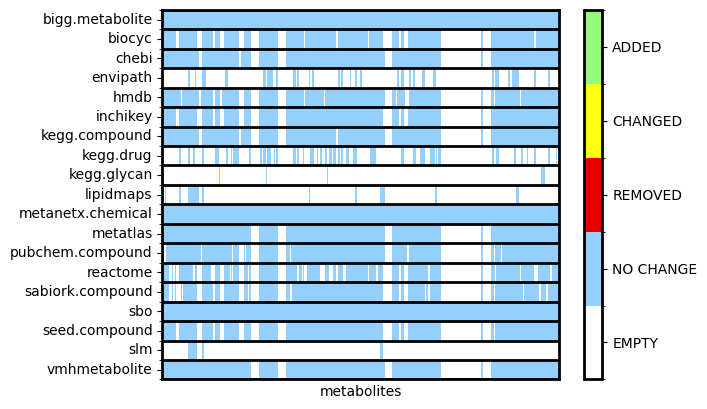

In [7]:
annotation_type = "metabolites"
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='genes'>

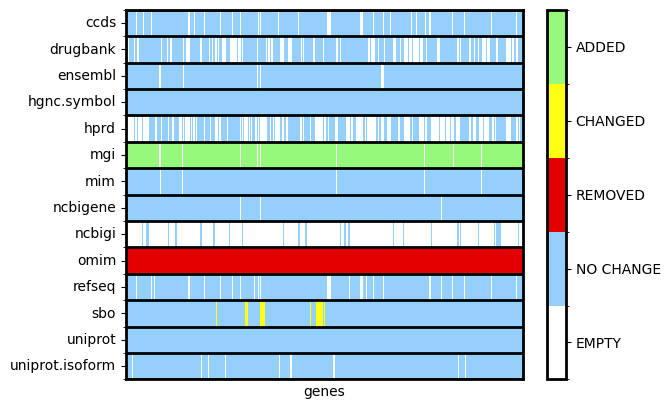

In [8]:
annotation_type = "genes"
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

### Add/reset SBO annotations

In [9]:
# for reaction in model.reactions:
#     if reaction.boundary and reaction in model.exchanges:
#         reaction.annotation["sbo"] = "SBO:0000627" # Exchange reaction
#     elif reaction.boundary and reaction in model.demands:
#         reaction.annotation["sbo"] = "SBO:0000628" # Demand reaction
#     elif reaction.boundary and reaction in model.sinks:
#         reaction.annotation["sbo"] = "SBO:0000632" # Sink reaction
#     elif len(reaction.compartments) > 1:
#         reaction.annotation["sbo"] = "SBO:0000185" # Transport reaction
#     else:
#         reaction.annotation["sbo"] = "SBO:0000176" # Biochemical reaction

# for metabolite in model.metabolites:
#     metabolite.annotation["sbo"] = "SBO:0000247" # Metabolite
   
# for gene in model.genes:
#     gene.annotation["sbo"] = "SBO:0000243" # Gene

## Export model

In [10]:
write_rbc_model(model, filetype="all")